# Predict driver first trip

A ridesharing company is interested in predicting which driver signups are most likely to start driving. A sample dataset of a cohort of driver signups is provided. The data was pulled a few months after they signed up to include the result of whether they actually completed their first trip. It also includes several pieces of background information gather about the driver and their car.

Here I want to use this data set to  understand what factors are best at predicting whether a signup will start to drive, and offer suggestions to operationalize those insights.

## summary of findings
- About 11% of sign up ended complete first trip. 
- The median days spent from signup to complete first trip is 11 days.
- there is a a funnel from signup, background check, adding vehicle to finally complete the first trip. 
- there is a bottleneck in the funnel in adding vehicle. 
- a random forest model is built for prediction and achieve a AUC of 0.91. 
- The predictive model can be used to efficiently allocate resources to help those who might not complete the first trip based on their background information. 

# Load libraries and data set

In [283]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score




In [3]:
# function for calculate time difference between signup to bgc and bgc to vehicle added
def extract_days(input_delta):
    delta = pd.Timedelta(input_delta)
    if pd.notnull(delta):
        days = delta.days

    # Return result
    return days

In [64]:
# load dataset
df = pd.read_csv('./data/input/ds_challenge_v2_1_data.csv')

In [5]:
df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN


In [156]:
# change type of object to date for columns involved date
df['signup_date'] = pd.to_datetime(df['signup_date'], format='%m/%d/%y')
df['bgc_date'] = pd.to_datetime(df['bgc_date'], format='%m/%d/%y')
df['vehicle_added_date'] = pd.to_datetime(df['vehicle_added_date'], format='%m/%d/%y')
df['first_completed_date'] = pd.to_datetime(df['first_completed_date'], format='%m/%d/%y')
df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,NaT
1,2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,NaT
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,NaT
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016.0,2016-02-03
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016.0,NaT


#  Exploratory analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 11 columns):
id                      54681 non-null int64
city_name               54681 non-null object
signup_os               47824 non-null object
signup_channel          54681 non-null object
signup_date             54681 non-null object
bgc_date                32896 non-null object
vehicle_added_date      13134 non-null object
vehicle_make            13223 non-null object
vehicle_model           13223 non-null object
vehicle_year            13223 non-null float64
first_completed_date    6137 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 4.6+ MB


In [7]:
print('completion rate: {:0.3f}'.format(6137/54681))

completion rate: 0.112


About 11% signup took a first trip.

## funnel
Here we explore the funnel effect.

The funnel process:signup -> bgc -> vehicle_added -> first_completed. 

signup_date             54681
bgc_date                32896
vehicle_added_date      13134
first_completed_date     6137
dtype: int64

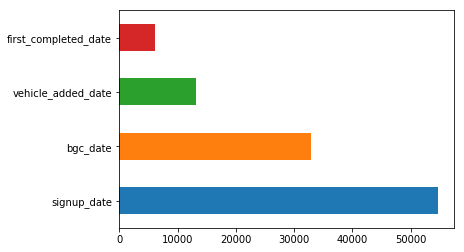

In [157]:
ser = df.iloc[:,[4,5,6,10]].count()
ser.plot(kind='barh')
ser

This graph shows the funnel from signup, background check, adding vehicle to finally complete the first trip. One can see the decrease of the numbers down the funnel. 


In [205]:
ser[1]/ser[0],ser[2]/ser[1],ser[3]/ser[2]

(0.6015983614052413, 0.3992582684824903, 0.4672605451499924)

Looking at the ratio of the steps in the funnel, we found that the vehicle_added to background check has the lowest ratio. So the background check is the bottleneck in our funnel. 

## first drive among cities

city_name
Berton     20117
Strark     29557
Wrouver     5007
Name: city_name, dtype: int64

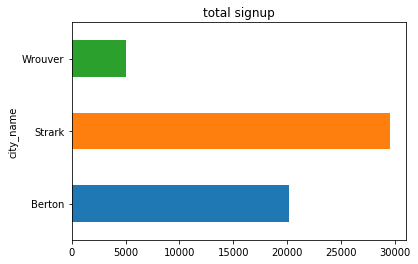

In [158]:
a = df.groupby('city_name').city_name.count()
a.plot(kind='barh')
plt.title('total signup')
a

city_name
Berton     20117
Strark     29557
Wrouver     5007
Name: city_name, dtype: int64

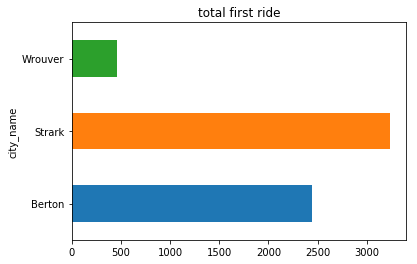

In [159]:
b = df.groupby('city_name').first_completed_date.count()
b.plot(kind='barh')
plt.title('total first ride')
a

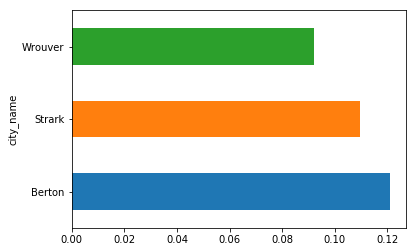

In [218]:
# what percentage of sign up at each cities?
c = df.groupby('city_name').first_completed_date.mean()
c.plot(kind='barh')


There is higher drive to signup rate at the city of Berton. The data provide us a motivation to understand how to increase signup at other two cities.

## signup_os

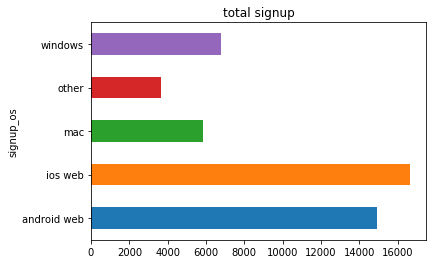

In [144]:
a = df.groupby('signup_os').signup_os.count()
a.plot(kind='barh')
plt.title('total signup')
plt.show()

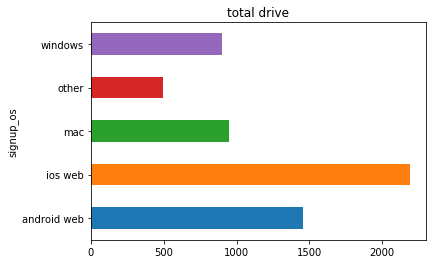

In [145]:
b = df.groupby('signup_os').first_completed_date.count()
b.plot(kind='barh')
plt.title('total drive')
plt.show()

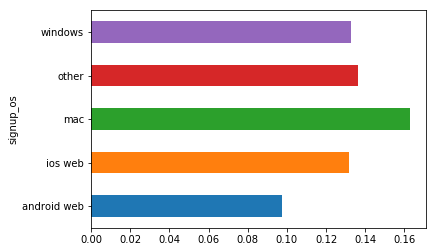

In [219]:
c = df.groupby('signup_os').first_completed_date.mean()
c.plot(kind='barh')

Highest drive to signup: mac. lowest: android. action: investigate why android user less likely to do first drive. 

## signup_channel

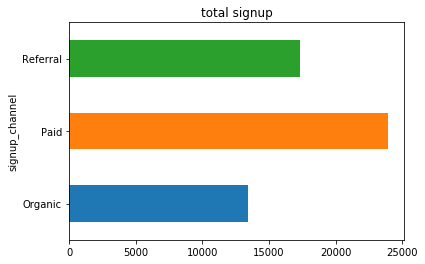

In [147]:
a = df.groupby('signup_channel').signup_channel.count()
a.plot(kind='barh')
plt.title('total signup')
plt.show()

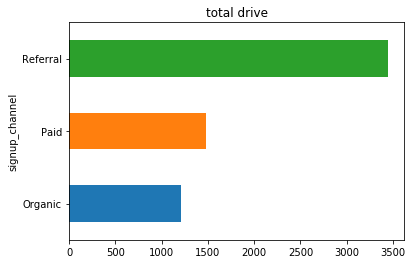

In [148]:
b = df.groupby('signup_channel').first_completed_date.count()
b.plot(kind='barh')
plt.title('total drive')
plt.show()

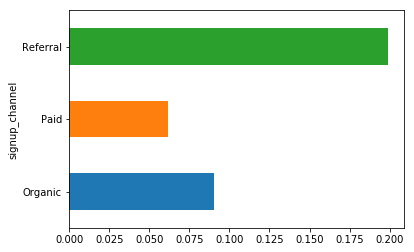

In [220]:
c = df.groupby('signup_channel').first_completed_date.mean()
c.plot(kind='barh')

Referral would increase signup to drive ratio.

## time it takes from signup to drive

Text(0.5,0,'days')

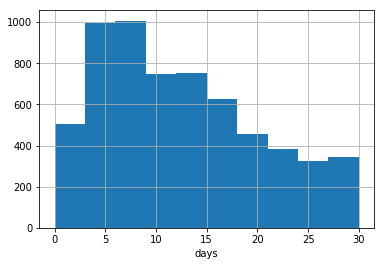

In [188]:
a = (df.first_completed_date-df.signup_date).dt.days
a.hist()
plt.xlabel('days')

In [189]:
a.median()

11.0

The median of days spent from signup to first drive is 11 days.

## Year of cars

In [193]:
df[df.vehicle_year!=0].vehicle_year.median()

2013.0

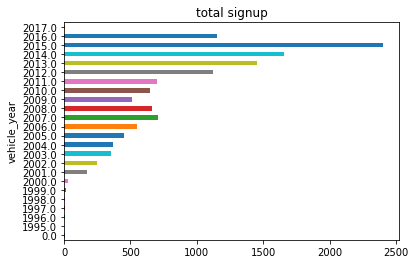

In [197]:
a = df.groupby('vehicle_year').vehicle_year.count()
a.plot(kind='barh')
plt.title('total signup')
plt.show()

Most car is pretty new with the year median at 2013.

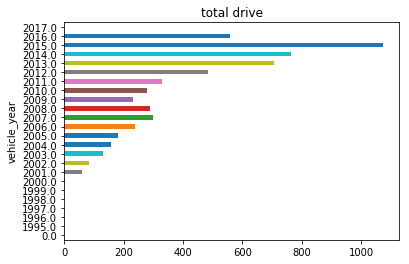

In [198]:
b = df.groupby('vehicle_year').first_completed_date.count()
b.plot(kind='barh')
plt.title('total drive')
plt.show()

**how does year of car affect signup to drive**

In [200]:
a.

vehicle_year
0.0          4
1995.0       1
1996.0       4
1997.0       6
1998.0      10
1999.0      14
2000.0      29
2001.0     169
2002.0     251
2003.0     350
2004.0     369
2005.0     450
2006.0     550
2007.0     711
2008.0     659
2009.0     513
2010.0     645
2011.0     702
2012.0    1122
2013.0    1451
2014.0    1655
2015.0    2402
2016.0    1150
2017.0       6
Name: vehicle_year, dtype: int64

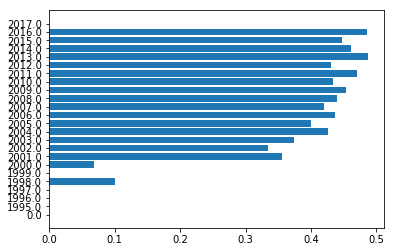

In [199]:
percent = b.values/a.values
x = range(len(percent))
plt.barh(x, percent)
plt.yticks(x, b.index.tolist())
plt.show()

# clean up dataframe

In [216]:
df.drop(['id','signup_date'],axis = 1 , inplace = True)

In [206]:
# fill na as zero and data with 1. 
df.first_completed_date.fillna(0,inplace = True)
df.loc[df.first_completed_date!=0,'first_completed_date']=1

In [207]:
df.bgc_date.fillna(0,inplace=True)
df.loc[df.bgc_date!=0,'bgc_date'] = 1

In [208]:
df.vehicle_year.fillna(0,inplace=True)
#df.loc[df.vehicle_added_date!=0,'vehicle_added_date'] = 1

In [235]:
df.vehicle_added_date.fillna(0,inplace=True)
df.loc[df.vehicle_added_date!=0,'vehicle_added_date'] = 1
df.vehicle_year = df.vehicle_year.astype('int')

In [210]:
# save the vehicle info for potential usage later
veh = df.loc[:,['vehicle_make','vehicle_model']]

In [211]:
# delete vehicle info
df.drop(['vehicle_make','vehicle_model'],axis=1,inplace=True)

In [212]:
# check if vehicle add date and vehicle year nan correspond to each other
a = df['vehicle_year']==0
b = df['vehicle_added_date']==0
sum(a==b)/54681


0.9982992264223405

Not all of them but very very closed. so we just ignore 'vehicle_added_date' and only keep 'vehicle_year' 

In [16]:
#veh['vehicle_added_date'] = df.vehicle_added_date

In [17]:

#df.drop('vehicle_added_date',axis=1,inplace=True)

In [223]:
df.signup_os.fillna('other',inplace=True)

In [25]:
# drop signup_date column as it does not add any info.
df.drop('signup_date',axis=1,inplace=True)

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 7 columns):
city_name               54681 non-null object
signup_os               54681 non-null object
signup_channel          54681 non-null object
bgc_date                54681 non-null int64
vehicle_added_date      54681 non-null int64
vehicle_year            54681 non-null float64
first_completed_date    54681 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 2.9+ MB


In [229]:
# do  encoding for the categorical variable
df["city_name"] = df["city_name"].astype('category').cat.codes
df["signup_os"] = df["signup_os"].astype('category').cat.codes
df["signup_channel"] = df["signup_channel"].astype('category').cat.codes

In [236]:
# final dataframe
df.head()

,city_name,signup_os,signup_channel,bgc_date,vehicle_added_date,vehicle_year,first_completed_date
0,1,1,1,0,0,0,0
1,1,4,1,0,0,0,0
2,2,4,0,1,0,0,0
3,0,0,2,1,1,2016,1
4,1,0,2,1,1,2016,0


In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 7 columns):
city_name               54681 non-null int8
signup_os               54681 non-null int8
signup_channel          54681 non-null int8
bgc_date                54681 non-null int64
vehicle_added_date      54681 non-null int64
vehicle_year            54681 non-null int64
first_completed_date    54681 non-null int64
dtypes: int64(4), int8(3)
memory usage: 1.8 MB


# upsampling

In [254]:
# prepare train and test set
X = df.loc[:,df.columns != 'first_completed_date']
y = df.first_completed_date
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.25,random_state=42)

In [267]:
df_train = X_train.join(y_train, how='outer')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41010 entries, 45178 to 1834
Data columns (total 7 columns):
city_name               41010 non-null int8
signup_os               41010 non-null int8
signup_channel          41010 non-null int8
bgc_date                41010 non-null int64
vehicle_added_date      41010 non-null int64
vehicle_year            41010 non-null int64
first_completed_date    41010 non-null int64
dtypes: int64(4), int8(3)
memory usage: 2.9 MB


In [269]:
# need to upsampled the sign up rate in train set
df_train.first_completed_date.value_counts()

0    36407
1     4603
Name: first_completed_date, dtype: int64

In [270]:
df_min = df_train[df_train.first_completed_date == 1]
df_maj = df_train[df_train.first_completed_date == 0]
df_min_up = resample(df_min,replace=True,n_samples = 36407, random_state = 123)


In [271]:
df_up = pd.concat([df_maj,df_min_up])

In [272]:
df_up.first_completed_date.value_counts()

1    36407
0    36407
Name: first_completed_date, dtype: int64

In [275]:
X_train = df_up.loc[:,df.columns != 'first_completed_date']
y_train = df_up.first_completed_date


# Build a predictive model 
to help Uber determine whether or not a driver signup will start driving. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.​ (2 points)

In [276]:
df_up.head()

,city_name,signup_os,signup_channel,bgc_date,vehicle_added_date,vehicle_year,first_completed_date
45178,1,0,2,1,0,0,0
10998,1,3,1,1,0,0,0
38,1,4,0,1,0,0,0
35556,1,0,1,1,1,2003,0
9409,0,1,2,0,0,0,0


## Build Random Forest Model

In [329]:
random_clf = RandomForestClassifier()
lr_clf = LogisticRegression()
cross_val_score(random_clf,X_train,y_train,scoring='f1'),cross_val_score(lr_clf,X_train,y_train,scoring='f1')

(array([0.91332756, 0.91486166, 0.91314941]),
 array([0.91214602, 0.91222558, 0.91100501]))

Text(0.5,1,'auc=0.914957')

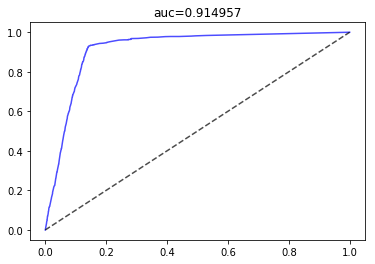

In [335]:
random_clf.fit(X_train,y_train)
pred_proba_test = random_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test,pred_proba_test[:,1] )
plt.plot(fpr,tpr,'b',alpha =0.7)
plt.plot([0,1],[0,1],'k--',alpha =0.7)
auc_score = roc_auc_score(y_test,pred_proba_test[:,1])
plt.title('auc=%f'% auc_score)

Text(0.5,1,'auc=0.920776')

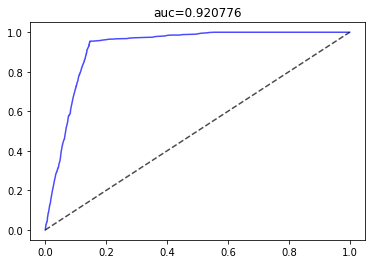

In [330]:
lr_clf.fit(X_train,y_train)
pred_proba_test = lr_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test,pred_proba_test[:,1] )
plt.plot(fpr,tpr,'b',alpha =0.7)
plt.plot([0,1],[0,1],'k--',alpha =0.7)
auc_score = roc_auc_score(y_test,pred_proba_test[:,1])
plt.title('auc=%f'% auc_score)

In [311]:
def y_pred(prob,t):
    return [1 if y >= t else 0 for y in prob]

In [331]:
li = np.arange(0,1,0.1)
f1_s = []
for i in li:
    ypred = y_pred(pred_proba_test[:,1],i)
    f1_s.append(f1_score(y_test,ypred))
f1_s

[0.2017757316672147,
 0.403386186509003,
 0.6020135607150195,
 0.6037502575726355,
 0.6091476091476091,
 0.6122022565816967,
 0.6124581939799331,
 0.6124581939799331,
 0.6077466295741493,
 0.27753934191702434]

In [278]:
confusion_matrix(y_test,random_clf.predict(X_test))

array([[10444,  1693],
       [  118,  1416]])

In [332]:
f1_score(y_test,lr_clf.predict(X_test))

0.6122022565816967

## identifying feature importance

In [336]:
list_importance = random_clf.feature_importances_
list_name = X.columns
list_importance,list_name = zip(*sorted(zip(list_importance,list_name)))

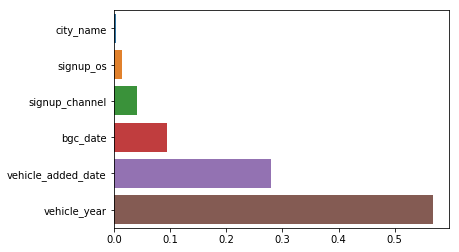

In [296]:
ax = sns.barplot(y=list_name, x=list_importance)